<a href="https://colab.research.google.com/github/s-jaume/covid19_data/blob/master/Housing_Price_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Loading Data

In [ ]:
# Import local files
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')

In [ ]:
#reading df in from mounted Gdrive
test_url = "/content/drive/My Drive/Spark_Workshop/test.csv"
testdf = pd.read_csv(test_url)
train_url = "/content/drive/My Drive/Spark_Workshop/train.csv"
traindf = pd.read_csv(train_url)

FileNotFoundError: ignored

In [ ]:
testdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
traindf.head()

In [ ]:
traindf.columns

#EDA and Visualization

In [ ]:
traindf.info()
#With a total of 1460 entries, some fetures have a lot of null values
#We should remove less important features
#Eg. Alley, FireplaceQu, PoolQC, 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
#describe the values in the df
traindf.describe().T

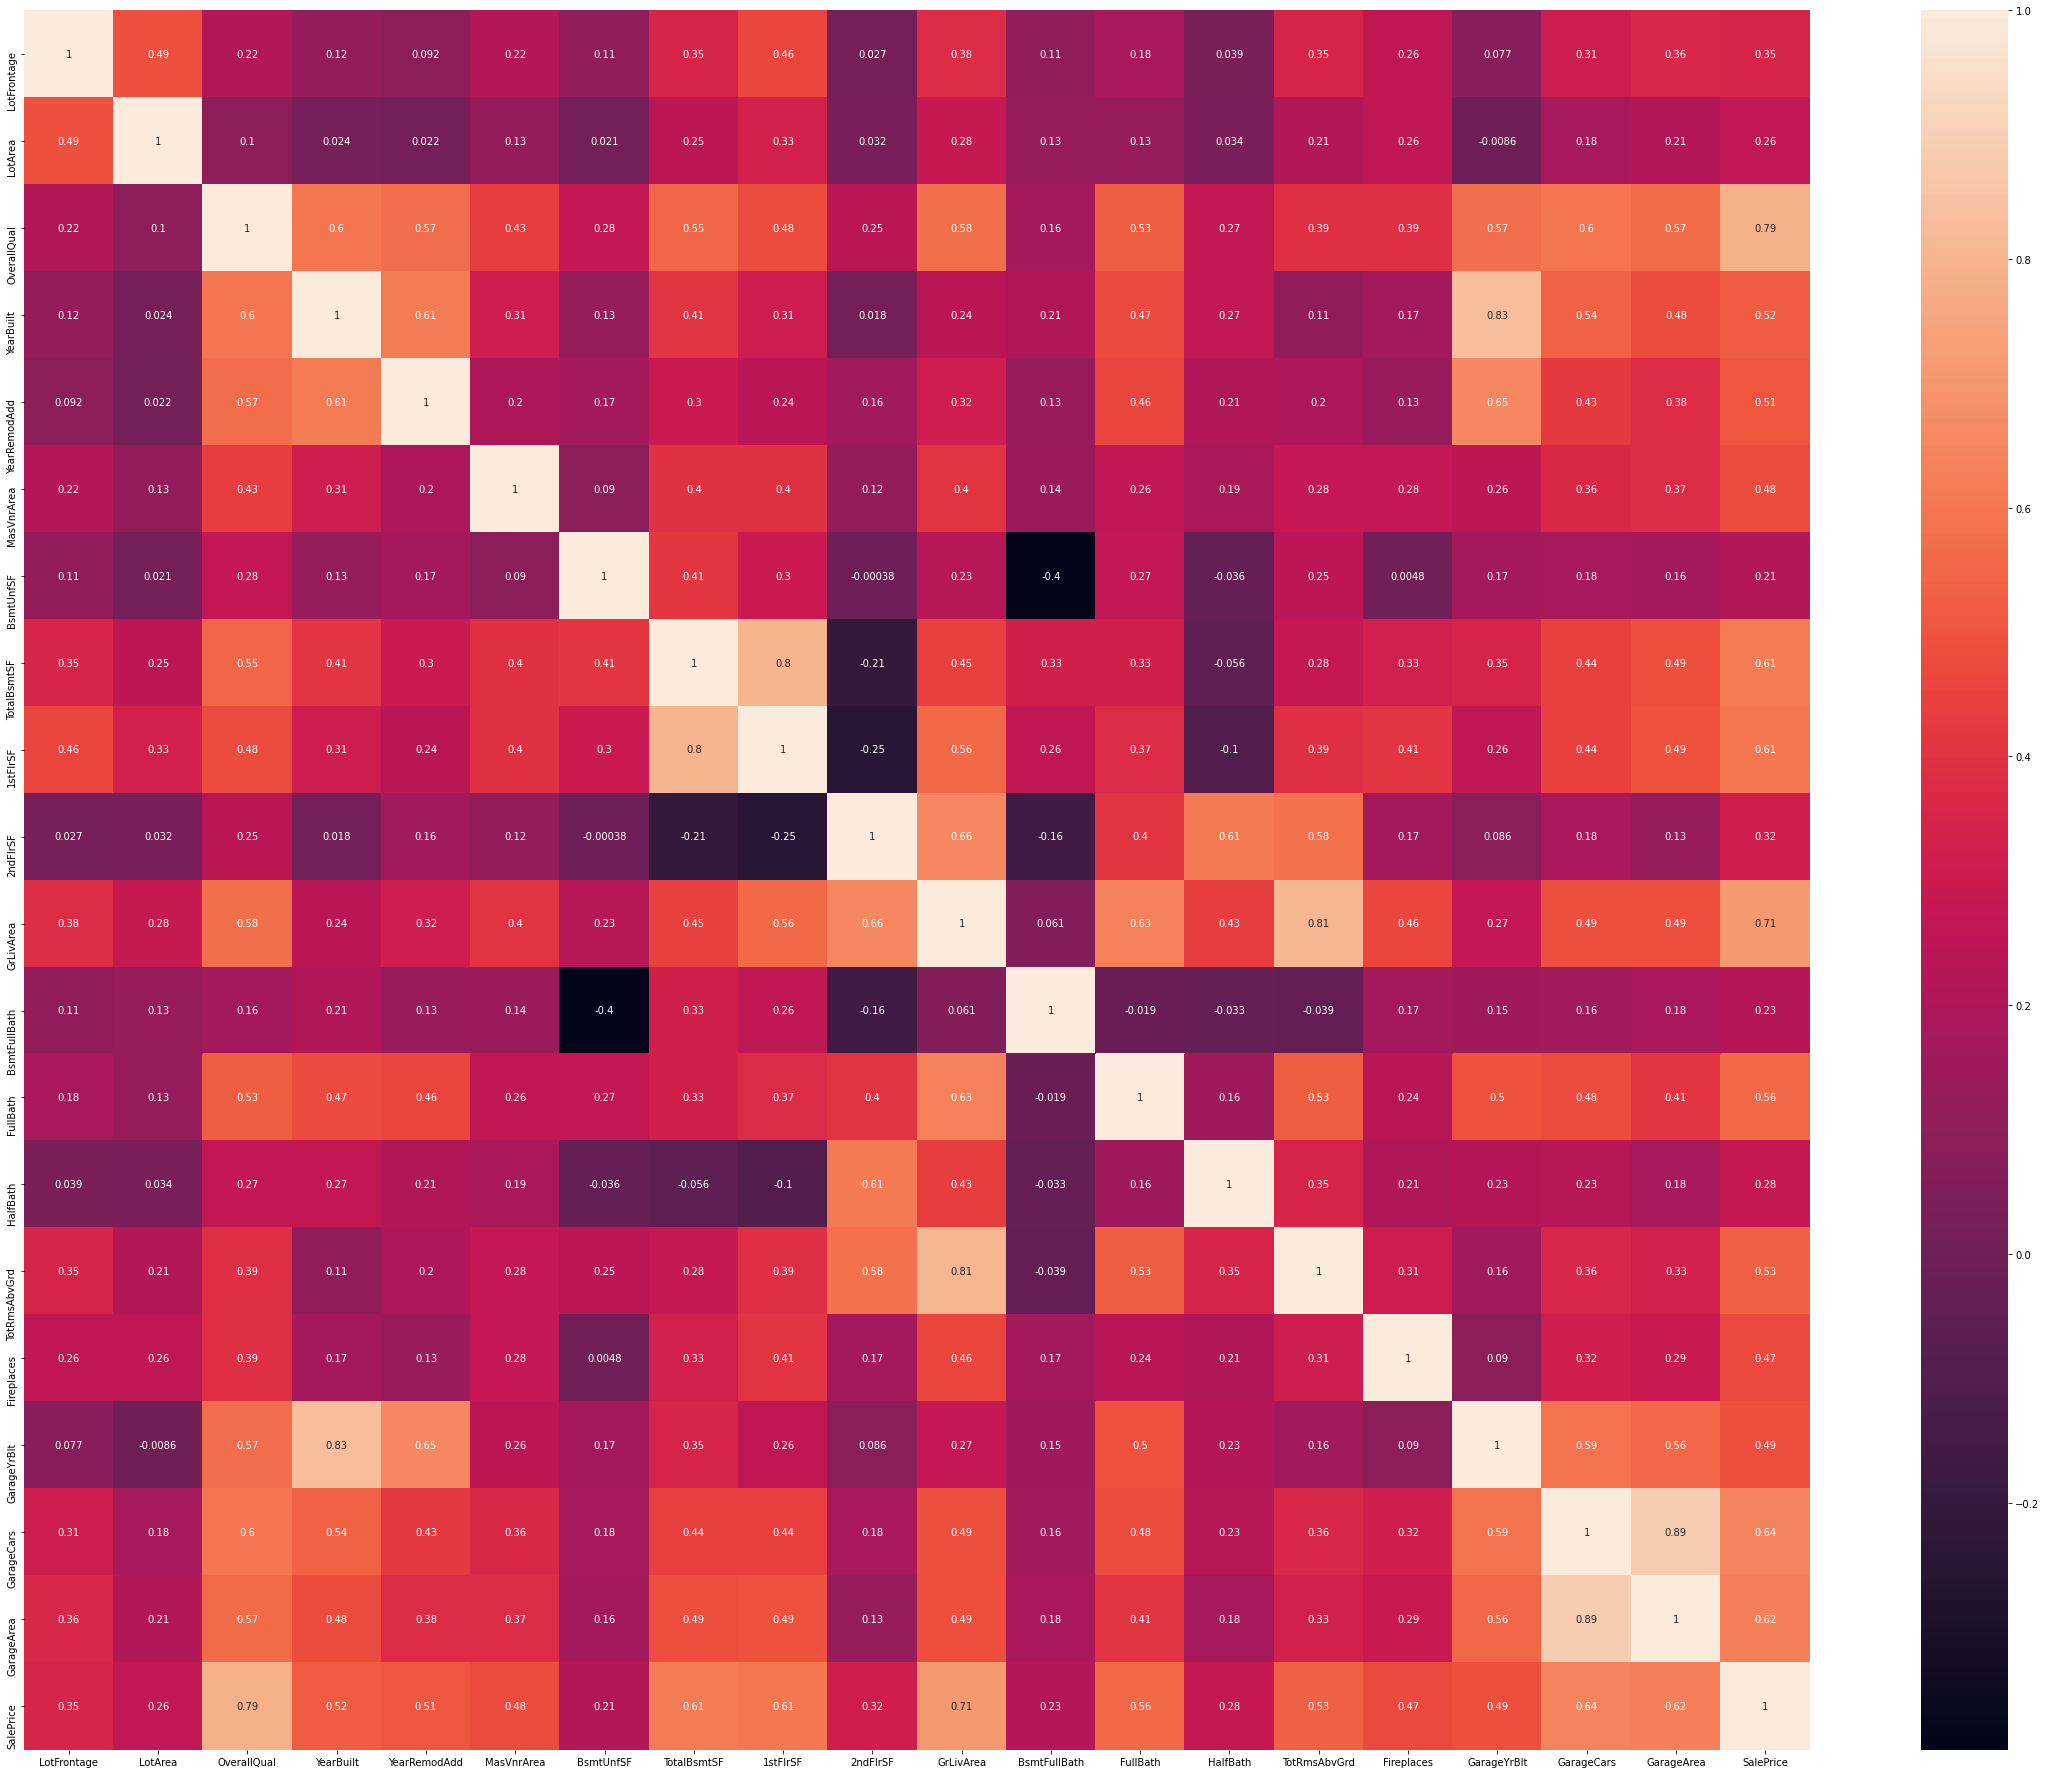

In [ ]:
all_data = pd.concat((traindf, testdf)).reset_index(drop=True)
corr_data = all_data.drop(columns=['Id','BedroomAbvGr','BsmtHalfBath','KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold', 'YrSold','WoodDeckSF','OpenPorchSF','BsmtFinSF1','BsmtFinSF2', 'LowQualFinSF', 'OverallCond', 'MSSubClass'])

fig, ax = plt.subplots(figsize=(40,32))
sns.heatmap(corr_data.corr(), annot=True)

In [ ]:
#Alter the size of the figure and the subplot
fig, ax = plt.subplots(figsize=(40,32))
#Create a heatmap of correlations

#.corr() finds the data correlation between all the columns in the df
#it creates a 2D table with the correlations; the heatmap adds color
#annot=True writes the data value in each cell
sns.heatmap(all_data.corr(), annot=True)

#the highest correlation to sales price is OverallQual and GrLiveArea
#the lowest correlation to sales price is KitchenAbGrnd and EnclosedPorch

#Notably, OverallCond has no correlation to price

#OverallQual is highly correlated to ~10 features
#Year built, Garage Features, Number of full baths
#Oddly, theres a high correlation to the OverallCond and YearGrgBuilt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


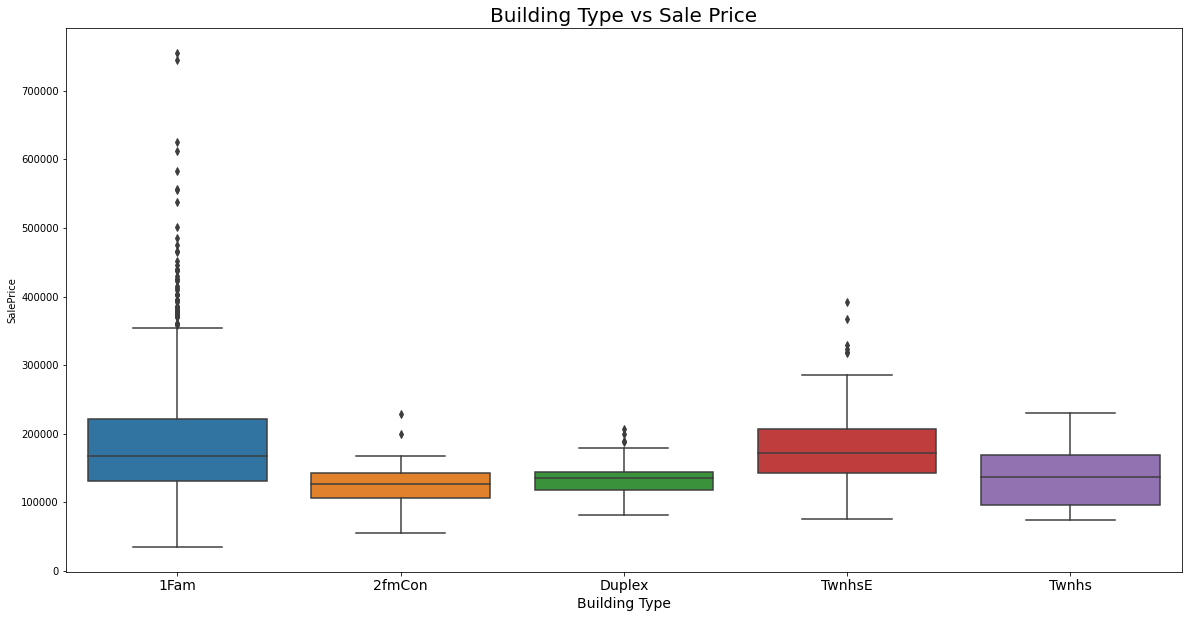

In [ ]:
#Also consider, non-numerical fields such as front area, utilities, etc
#Use this chunk of code to plot price by a categorical field
#Is there a way for us to plot multiple of these categorical fields?

plt.figure(figsize=(20,10))
sns.boxplot(traindf.BldgType, traindf.SalePrice)
plt.title("Building Type vs Sale Price", size=20)
plt.xlabel("Building Type", size=14)
plt.xticks(size=14)
plt.show()

In [ ]:
#Select fields with highest correlation to price
filtered_traindf = traindf[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'LotFrontage', 'LotArea', 'MasVnrArea']]
filtered_traindf.head()

In [ ]:
#Plot Overall Quality to SalesPrice to see std dev
plt.figure(figsize=(20,10))
sns.boxplot(traindf.OverallQual, traindf.SalePrice)
plt.title("Overall Quality vs Sale Price", size=20)
plt.xlabel("Overall Quality", size=14)
plt.xticks(size=14)
plt.show()

#Clean Data

In [ ]:
print(traindf.FireplaceQu)

# Identify and Eliminate Outliers

#Preparing data for Model

In [ ]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [ ]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(traindf.shape))
print("The test data size before dropping Id feature is : {} ".format(testdf.shape))

#Save the 'Id' column
train_ID = traindf['Id']
test_ID = testdf['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
traindf.drop("Id", axis = 1, inplace = True)
testdf.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(traindf.shape)) 
print("The test data size after dropping Id feature is : {} ".format(testdf.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


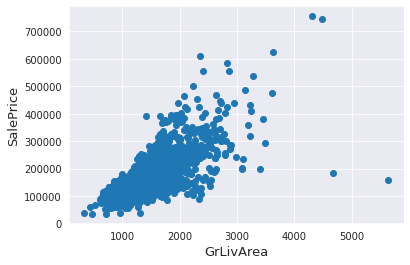

In [ ]:
#plot outliers
fig, ax = plt.subplots()
ax.scatter(x = traindf['GrLivArea'], y = traindf['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

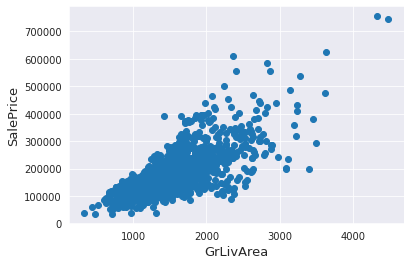

In [ ]:
#Deleting outliers
#deleting the two points in the bottom right
traindf = traindf.drop(traindf[(traindf['GrLivArea']>4000) & (traindf['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(traindf['GrLivArea'], traindf['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180921.20 and sigma = 79415.29



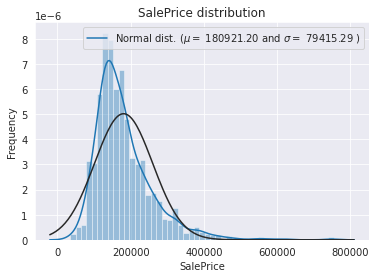

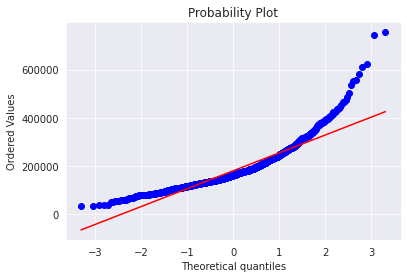

In [ ]:
#some analysis on target variable - sales price

sns.distplot(traindf['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(traindf['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
#The QQ plot plots the probability of a normal distribution to that of the data
fig = plt.figure()
res = stats.probplot(traindf['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


 mu = 12.02 and sigma = 0.40



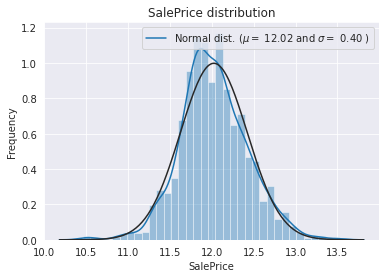

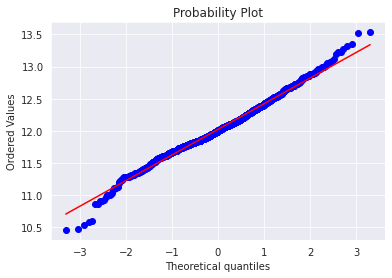

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
traindf["SalePrice"] = np.log1p(traindf["SalePrice"])

#Check the new distribution 
sns.distplot(traindf['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(traindf['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(traindf['SalePrice'], plot=plt)
plt.show()

#by adding log(1+x) to the test data set (applying a log transformat#ion), the distributiion adheres closely to a normal distribution

#Feature Engineering

In [ ]:
#putting train and test in the same df
ntrain = traindf.shape[0]
ntest = testdf.shape[0]
y_train = traindf.SalePrice.values
#merging the train and test since they are 50/50 distribution
#most ML models deal with 80/20
all_data = pd.concat((traindf, testdf)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [ ]:
#missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

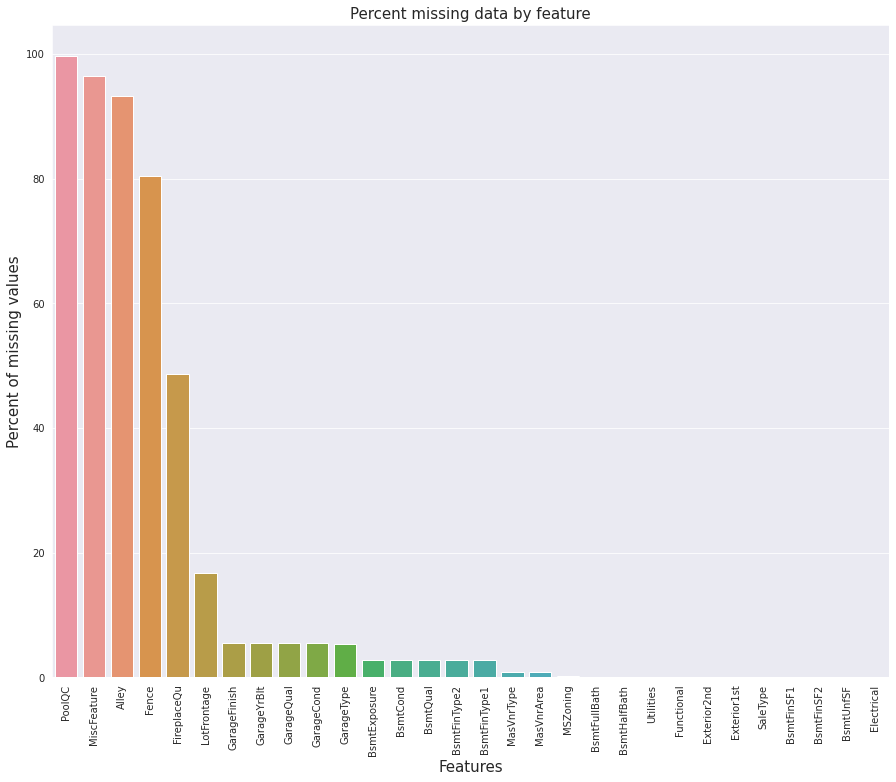

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [ ]:
#Fill "None" for PoolQC, MiscFeature

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

all_data["Alley"] = all_data["Alley"].fillna("None")

all_data["Fence"] = all_data["Fence"].fillna("None")

all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')    

#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

all_data.head()

#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
BsmtHalfBath,0.069
BsmtFullBath,0.069
Utilities,0.069
TotalBsmtSF,0.034
BsmtUnfSF,0.034


Transforming some numerical variables that are really categorical

In [ ]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

Label Encoding some categorical variables that may contain information in their ordering set

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 79)


In [ ]:
#Adding one more important feature - total square footage

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#skwed features

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.145323
EnclosedPorch,4.003891
ScreenPorch,3.946694


Box Cox Transformation of (highly) skewed features

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
train = all_data[:ntrain]
test = all_data[ntrain:]

(2917, 222)


##Modelling

In [ ]:
import sklearn
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Using RMSE as a validation function (root mean squared error)

In [ ]:
#Validation function
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

###Baseline Model

In [ ]:
#LASSO model, can tune hyperparameter to increase/decrease performance, but just a reference
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#Kernel Ridge Model
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#Gradient Boosting Regression 
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


In [ ]:
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(GBoost)
print("Gradient Boost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: ignored

##Simple Stacked Regression Model

Averaging base models 

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [ ]:
averaged_models = AveragingModels(models = (GBoost, KRR, lasso))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: ignored

##Deep learning model

Using a regression based deep learning model 

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [ ]:
train.describe()

Building a deep learning model with 4 layers

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               28544     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 193,409
Trainable params: 193,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
history = NN_model.fit(train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
37/37 [==============================] - 14s 20ms/step - loss: 176171.0432 - mean_absolute_error: 176171.0432 - val_loss: 172681.7500 - val_mean_absolute_error: 172681.7500

Epoch 00001: val_loss improved from inf to 172681.75000, saving model to Weights-001--172681.75000.hdf5
Epoch 2/500
37/37 [==============================] - 0s 4ms/step - loss: 132922.0294 - mean_absolute_error: 132922.0294 - val_loss: 48318.1914 - val_mean_absolute_error: 48318.1914

Epoch 00002: val_loss improved from 172681.75000 to 48318.19141, saving model to Weights-002--48318.19141.hdf5
Epoch 3/500
37/37 [==============================] - 0s 4ms/step - loss: 45670.2683 - mean_absolute_error: 45670.2683 - val_loss: 45067.9219 - val_mean_absolute_error: 45067.9219

Epoch 00003: val_loss improved from 48318.19141 to 45067.92188, saving model to Weights-003--45067.92188.hdf5
Epoch 4/500
37/37 [==============================] - 0s 4ms/step - loss: 45478.3488 - mean_absolute_error: 45478.3488 - val_los

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


In [ ]:
print(NN_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               28544     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 193,409
Trainable params: 193,409
Non-trainable params: 0
_________________________________________________________________
None


loading test

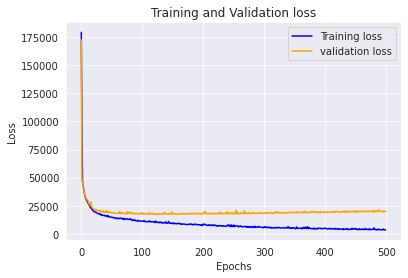

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,500)
plt.plot(epochs, np.array(loss_train), 'blue', label='Training loss')
plt.plot(epochs, np.array(loss_val), 'orange', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = NN_model.predict(test)

In [ ]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':test_ID,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')
predictions = NN_model.predict(test)
#predictions = NN_model.predict(test)
#print(predictions)
#result = pd.DataFrame
make_submission(predictions[:,0],'submission2')

A submission file has been made
